In [2]:
import sqlite3

import os
import re

import numpy as np
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:
from numpy import array, zeros, exp, random, dot
from numpy import shape, reshape, meshgrid, linspace
from numpy import hstack, vstack

import pandas as pd
print('Panda Version:', pd.__version__)

# Set ipython's max row display
pd.set_option('display.max_row', 100, 'display.max_columns', 25)

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100 # highres display

import tensorflow as tf
from tensorflow import Variable

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector

from keras.optimizers import SGD

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM, Dense, Concatenate

from keras.optimizers import SGD

import collections
from collections import Counter

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import date class from datetime module
import time
import datetime
# import datetime as dt
from datetime import date
print("Today date is: ", date.today())

Panda Version: 2.2.2


2024-08-13 13:49:15.756217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 13:49:15.773323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 13:49:15.778526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Today date is:  2024-08-13


In [3]:
!pwd

!ls -la /workspace/data/crypto_md/

/workspace/leo
total 15712
drwxrwxrwx 1 1000 1000     628 Aug 13 13:00 .
drwxrwxr-x 1 1000 1000      18 Jun  3 23:40 ..
drwxrwxr-x 1 1000 1000    1500 Aug 10 21:00 2024-06
drwxrwxr-x 1 1000 1000    1550 Aug 10 21:00 2024-07
-rw------- 1 1000 1000 1425408 Aug  2 13:01 20240801.mktdata.ohlcv.db
-rw------- 1 1000 1000 1396736 Aug  3 13:01 20240802.mktdata.ohlcv.db
-rw------- 1 1000 1000 1384448 Aug  4 13:01 20240803.mktdata.ohlcv.db
-rw------- 1 1000 1000 1318912 Aug  6 02:54 20240804.mktdata.ohlcv.db
-rw------- 1 1000 1000 2269184 Aug 10 17:04 20240805.mktdata.ohlcv.db
-rw------- 1 1000 1000 1146880 Aug 10 20:59 20240806.mktdata.ohlcv.db
-rw------- 1 1000 1000 1363968 Aug  8 13:01 20240807.mktdata.ohlcv.db
-rw------- 1 1000 1000 1187840 Aug 10 17:09 20240808.mktdata.ohlcv.db
-rw------- 1 1000 1000 1028096 Aug 10 17:10 20240809.mktdata.ohlcv.db
-rw------- 1 1000 1000 1187840 Aug 11 13:00 20240810.mktdata.ohlcv.db
-rw------- 1 1000 1000 1187840 Aug 12 13:00 20240811.mktdata.ohlcv.db
-rw---

In [82]:
# db_conn = sqlite3.connect(mktdata_db_file)
# tables_df = pd.read_sql_query("select * from sqlite_master where type = 'table'", db_conn)
# print (tables_df_20240601.head())

In [4]:
directory = "/workspace/data/crypto_md"

# List of dates
dates = ['20240601', 
         '20240602', 
         '20240603', 
         '20240604', 
         '20240605', 
         '20240606', 
         '20240607', 
         '20240608', 
         '20240609',
         '20240610',
         '20240611',
         '20240612',
         '20240613', 
         '20240614', 
         '20240615', 
         '20240616']        

# Create an entirely empty DataFrame
df_concat = pd.DataFrame()

for date in dates:
    # Construct the filename
    filename = f"{directory}/{date}.mktdata.ohlcv.db"
    
    # Create the SQLite connection
    conn = sqlite3.connect(filename)
    
    # Read the data into a DataFrame
    df = pd.read_sql_query("select * from coinbase_ohlcv_1min", conn)

    df_concat = pd.concat([df_concat, df], axis = 0,ignore_index = True)
    # Print the combined DataFrame
    # print(df_concat.shape[0])
    # print(df_concat.shape[1])
    conn.close()
print(df_concat.shape[0])
# print(df_concat.head(2))
# print(df_concat.tail(2))

DatabaseError: Execution failed on sql 'select * from coinbase_ohlcv_1min': no such table: coinbase_ohlcv_1min

In [4]:
df_concat['tstamp'] = pd.to_datetime(df_concat['tstamp'])
# Extract individual components
df_concat['year'] = df_concat['tstamp'].dt.year
df_concat['month'] = df_concat['tstamp'].dt.month
df_concat['day'] = df_concat['tstamp'].dt.day
df_concat['hour'] = df_concat['tstamp'].dt.hour
df_concat['minute'] = df_concat['tstamp'].dt.minute
df_concat['second'] = df_concat['tstamp'].dt.second

df_concat['date'] = df_concat['day'].astype(str) + '-' + df_concat['hour'].astype(str) + '-' + df_concat['minute'].astype(str)
df_concat = df_concat.sort_values(by = ['day', 'hour', 'minute'])

selected_columns = ['date', 'instrument_id', 'close', 'volume', 'vwap']
df_concat = df_concat[selected_columns]

# instrument_list = df_concat['instrument_id'].unique().tolist()
# print("Distinct values in column 'instrument_id':", instrument_list)



In [6]:
# BTC
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']

# Reset Index
df_concat_btc = df_concat_btc.reset_index(drop = True)

# Rename Vars
df_concat_btc['close_btc'] = df_concat_btc['close']/100000.00
df_concat_btc['volume_btc'] = df_concat_btc['volume']
df_concat_btc['vwap_btc'] = df_concat_btc['vwap']/100000.00

df_concat_btc = df_concat_btc.drop('close', axis = 1)
df_concat_btc = df_concat_btc.drop('volume', axis = 1)
df_concat_btc = df_concat_btc.drop('vwap', axis = 1)
df_concat_btc = df_concat_btc.drop('instrument_id', axis = 1)

# print (df_concat_btc.head(3))

# LTC
df_concat_ltc = df_concat[df_concat['instrument_id'] == 'PAIR-LTC-USD']

# Reset Index
df_concat_ltc = df_concat_ltc.reset_index(drop = True)

# Rename Vars
df_concat_ltc['close_ltc'] = df_concat_ltc['close']/100.00
df_concat_ltc['volume_ltc'] = df_concat_ltc['volume']
df_concat_ltc['vwap_ltc'] = df_concat_ltc['vwap']/100.00

df_concat_ltc = df_concat_ltc.drop('close', axis = 1)
df_concat_ltc = df_concat_ltc.drop('volume', axis = 1)
df_concat_ltc = df_concat_ltc.drop('vwap', axis = 1)
df_concat_ltc = df_concat_ltc.drop('instrument_id', axis = 1)

# print (df_concat_ltc.head(3))

# ETH
df_concat_eth = df_concat[df_concat['instrument_id'] == 'PAIR-ETH-USD']

# Reset Index
df_concat_eth = df_concat_eth.reset_index(drop = True)

# Rename Vars
df_concat_eth['close_eth'] = df_concat_eth['close']/10000.00
df_concat_eth['volume_eth'] = df_concat_eth['volume']
df_concat_eth['vwap_eth'] = df_concat_eth['vwap']/10000.00

df_concat_eth = df_concat_eth.drop('close', axis = 1)
df_concat_eth = df_concat_eth.drop('volume', axis = 1)
df_concat_eth = df_concat_eth.drop('vwap', axis = 1)
df_concat_eth = df_concat_eth.drop('instrument_id', axis = 1)

# print (df_concat_eth.head(3))

# XRP
df_concat_xrp = df_concat[df_concat['instrument_id'] == 'PAIR-XRP-USD']

# Reset Index
df_concat_xrp = df_concat_xrp.reset_index(drop = True)

# Rename Vars
df_concat_xrp['close_xrp'] = df_concat_xrp['close']
df_concat_xrp['volume_xrp'] = df_concat_xrp['volume']
df_concat_xrp['vwap_xrp'] = df_concat_xrp['vwap']

df_concat_xrp = df_concat_xrp.drop('close', axis = 1)
df_concat_xrp = df_concat_xrp.drop('volume', axis = 1)
df_concat_xrp = df_concat_xrp.drop('vwap', axis = 1)
df_concat_xrp = df_concat_xrp.drop('instrument_id', axis = 1)

# print (df_concat_xrp.head(3))

df_M1 = pd.merge(df_concat_xrp, df_concat_eth, on = 'date', how = 'outer')
# print (df_M1.head(3))
# print ("M1:  ", df_M1.shape[0])
df_M2 = pd.merge(df_M1, df_concat_ltc, on = 'date', how = 'outer')
# print (df_M2.head(3))
# print ("M2:  ", df_M2.shape[0])
df_M3 = pd.merge(df_M2, df_concat_btc, on = 'date', how = 'outer')
# print (df_M3.head(3))
# print ("M3:  ", df_M3.shape[0])

# Drop rows with any NaN value and assign it to a new DataFrame
sample = df_M3.dropna(axis = 0).reset_index(drop = True)
print ("========================================")
print (sample.head(3))
sample_size = sample.shape[0]
print ("test sample size: ", sample_size)

     date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0   1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   
1   1-0-1     0.5170  10184.511212  0.517060   0.375942   11.703305  0.376013   
2  1-0-10     0.5176  15515.348778  0.517601   0.375938   11.922897  0.375935   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  
0     0.8317  110.056253  0.831662   0.675060    2.045049  0.674969  
1     0.8312  176.868598  0.831441   0.674947    0.646759  0.675009  
2     0.8311   58.951033  0.831037   0.675507    1.201335  0.675478  
test sample size:  22424


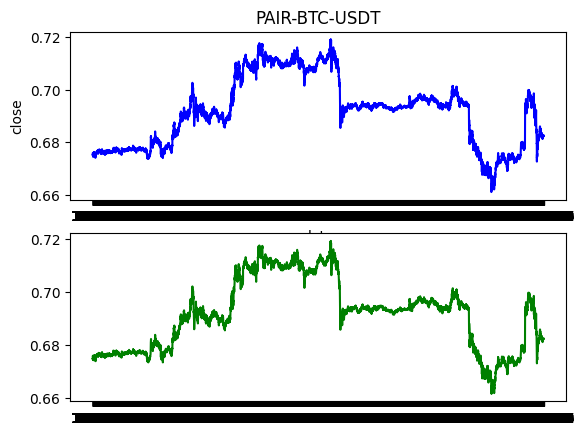

In [177]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_btc['date'], df_concat_btc['close_btc'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')

# Customize the plot
ax[0].set_title('PAIR-BTC-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()

In [7]:
split_index = round(sample.shape[0] * 0.8)

# First part of the DataFrame
sample_test = sample.iloc[:split_index]

# Second part of the DataFrame
sample_valid = sample.iloc[split_index:]

print("\nFirst part of the DataFrame:")
print (sample_test.tail(2))

print("\nSecond part of the DataFrame:")
print (sample_valid.head(2))


First part of the DataFrame:
         date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
17937  6-7-20     0.5232  49433.678414  0.523313   0.384779   27.276124   
17938  6-7-21     0.5233    801.681295  0.523286   0.384825    9.953973   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
17937  0.384768     0.8462  170.281602  0.846104   0.709604    0.941874   
17938  0.384780     0.8475  338.862661  0.846593   0.709634    0.190872   

       vwap_btc  
17937  0.709530  
17938  0.709608  

Second part of the DataFrame:
         date  close_xrp   volume_xrp  vwap_xrp  close_eth  volume_eth  \
17939  6-7-22     0.5229  8344.906144  0.523054   0.384777    5.698963   
17940  6-7-23     0.5229  4108.984575  0.522904   0.384792   31.878562   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
17939  0.384822     0.8473   67.170996  0.847403   0.709429    0.818917   
17940  0.384741     0.8474   32.162817  0.847309   0.709656 

In [172]:
# variables are close and volume
# ==============================
#  Test Sample --- 06.17.2024
# ==============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

sl = 8 # <--- sequence length
batch = 100  # <--- batch size
n_features = 8 # <---- no. of variables
n_out = 1 # <----- no. of predicted variables
frwd = 1  # <--- how many to predict

# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
    # Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)
    
# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
    # Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
    # Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]


X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
                      X_ETH_close, X_ETH_volume, 
                      X_LTC_close, X_LTC_volume, 
                      X_BTC_close, X_BTC_volume))
# print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X)
print (X.shape)

y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
print (y)

y = y_BTC.reshape(batch-cnt_thrown_idx, frwd, n_out)
print ('YYYY ====== Actual Input ====== YYYY')
print (y)
print (y.shape)

sample_size:  17939
[ 1384  5757 16213 13069 13373  6000 13791  4981 10888  8316  2533  5742
  9334 10830 17542  9836 11376  1664 16224  3630 10028 12874 11194  1160
 14281  5410 10529 11583 14703  6138  9215 11697 13449  7512  2548  3457
 15383  8654 12674  2381   295 15015  4884 11299 16782  4391 10095  6513
  3652  6528 14073 17098  9411  4580  7166  9903  9486 11610 12676 13070
  6903 16818 11461  1043 11513 11574 13418  4472  7134  6228 15303  5823
 14108  1230  1677 15232  4179  3161 16294  8711  5301  9021  2673  9559
 10899 11601  7617   796  2841   263 12059  2439  8251  5510  7132  4027
  1886 15771   354  3241]
XXXX ====== Actual Input ====== XXXX
[[[5.20000000e-01 8.56084855e+03 3.79046000e-01 ... 2.03619299e+01
   6.76403300e-01 1.93662680e-01]
  [5.20000000e-01 2.72118622e+02 3.79189000e-01 ... 8.46549397e+00
   6.76504300e-01 4.19622650e-01]
  [5.20000000e-01 2.79186141e+03 3.79209000e-01 ... 9.51299285e+00
   6.76559900e-01 3.23554580e-01]
  ...
  [5.20000000e-01 2.3455

/tmp/ipykernel_936/4176381576.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_test['Selected'] = 0


In [147]:
# 06.05.2024 just helper
values = X_BTC_close.reshape(batch-cnt_thrown_idx, sl)

print (values[0])
print (np.mean(values[0]))
print (np.std(values[0]))

[0.677093  0.6770824 0.67724   0.6770763 0.6770743 0.6768482 0.6769969
 0.6765836]
0.6769993375000001
0.00018735635789518952


0


<Figure size 1200x600 with 0 Axes>

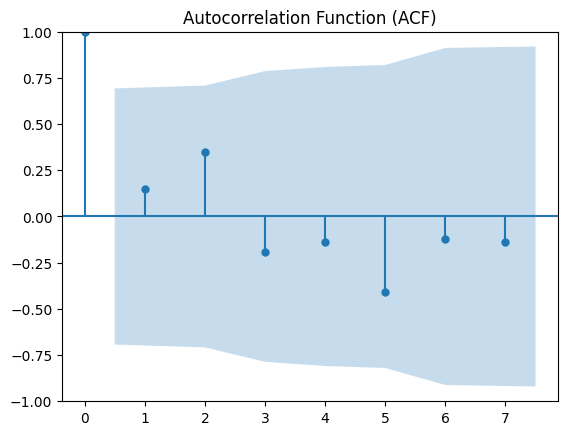

1


<Figure size 1200x600 with 0 Axes>

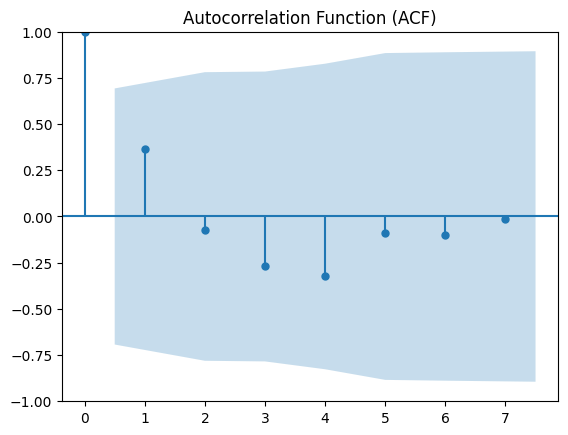

2


<Figure size 1200x600 with 0 Axes>

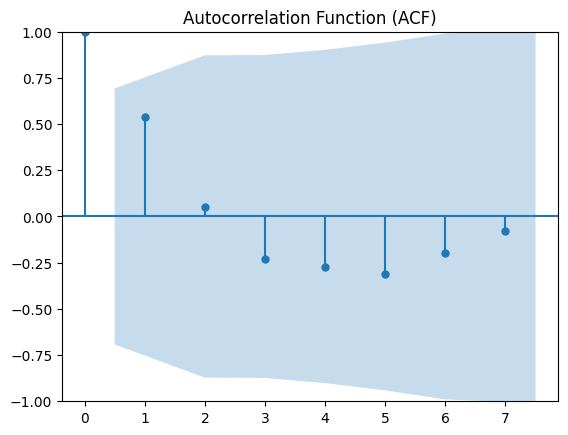

3


<Figure size 1200x600 with 0 Axes>

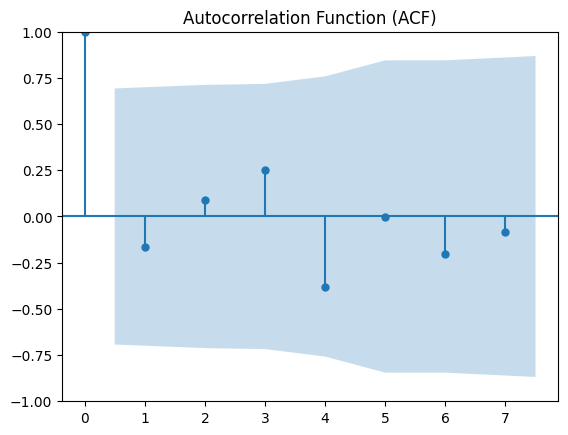

4


<Figure size 1200x600 with 0 Axes>

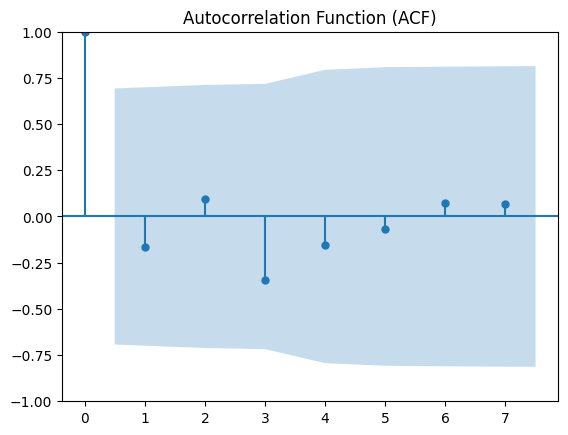

5


<Figure size 1200x600 with 0 Axes>

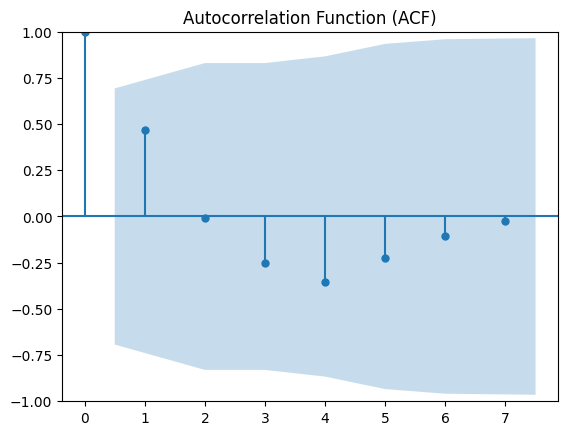

6


<Figure size 1200x600 with 0 Axes>

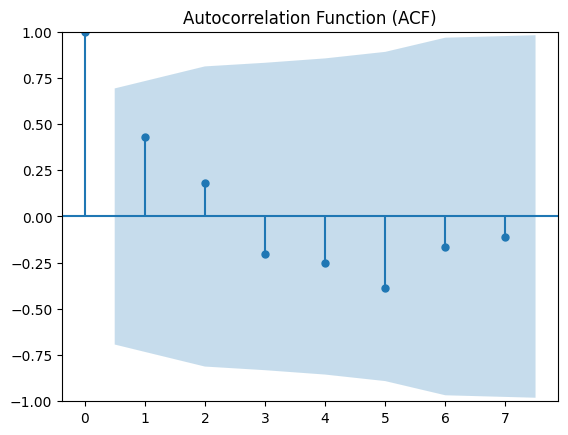

7


<Figure size 1200x600 with 0 Axes>

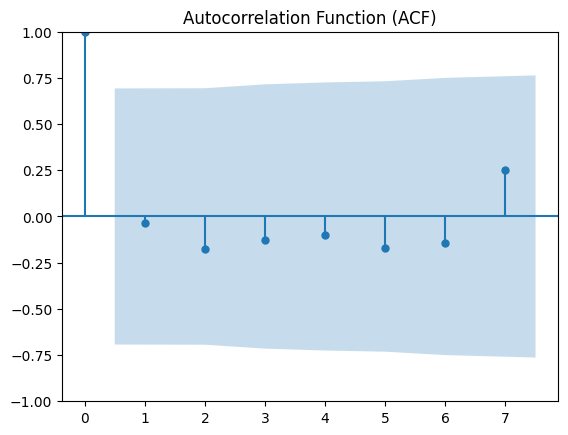

8


<Figure size 1200x600 with 0 Axes>

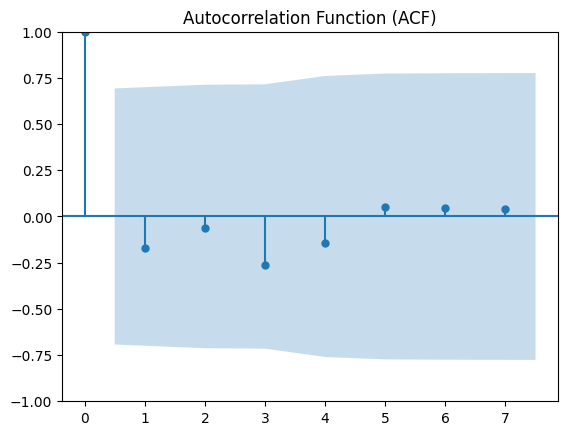

9


<Figure size 1200x600 with 0 Axes>

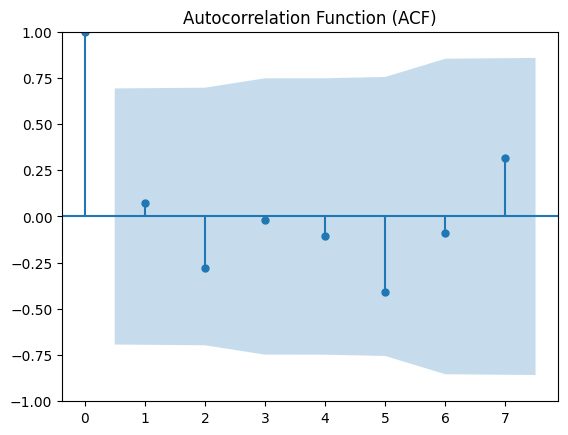

10


<Figure size 1200x600 with 0 Axes>

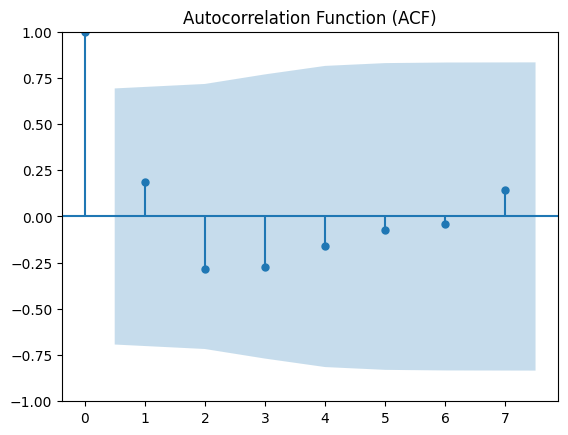

11


<Figure size 1200x600 with 0 Axes>

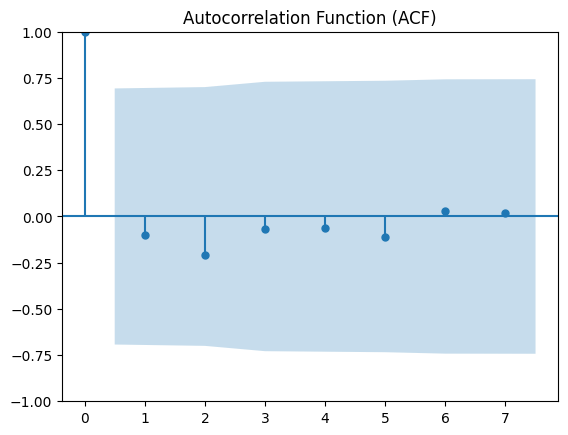

12


<Figure size 1200x600 with 0 Axes>

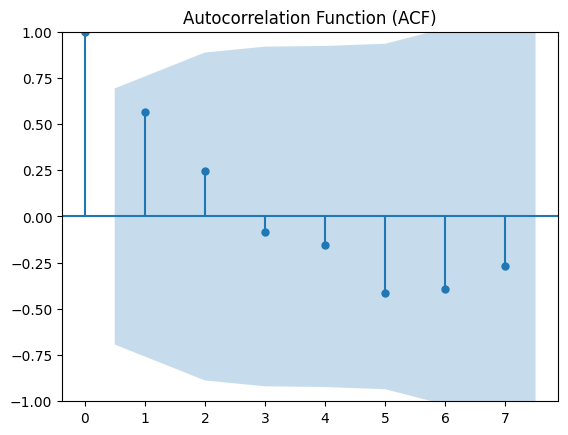

13


<Figure size 1200x600 with 0 Axes>

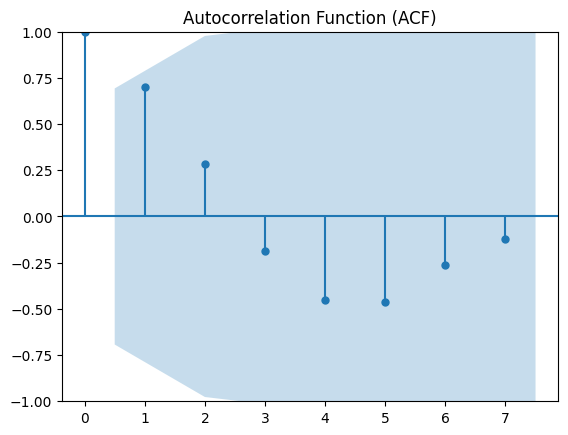

14


<Figure size 1200x600 with 0 Axes>

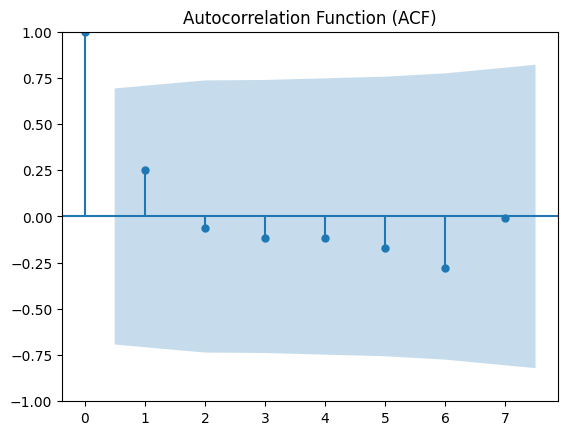

15


<Figure size 1200x600 with 0 Axes>

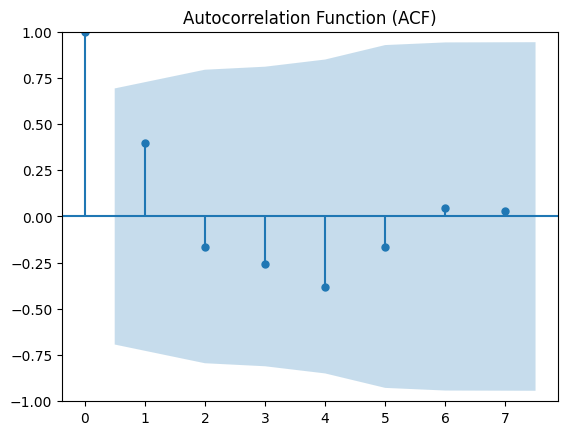

16


<Figure size 1200x600 with 0 Axes>

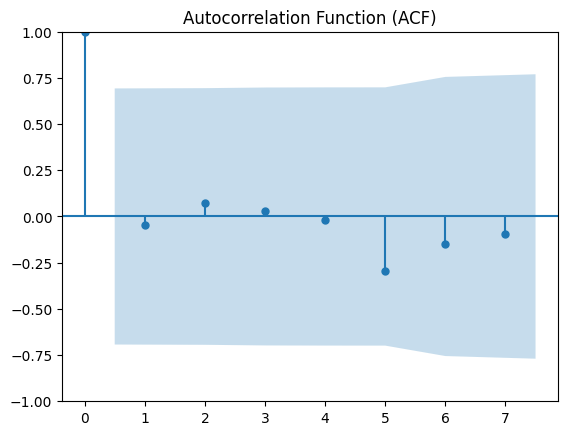

17


<Figure size 1200x600 with 0 Axes>

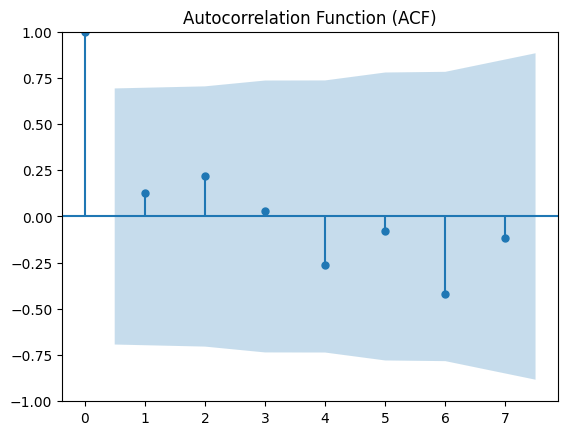

18


<Figure size 1200x600 with 0 Axes>

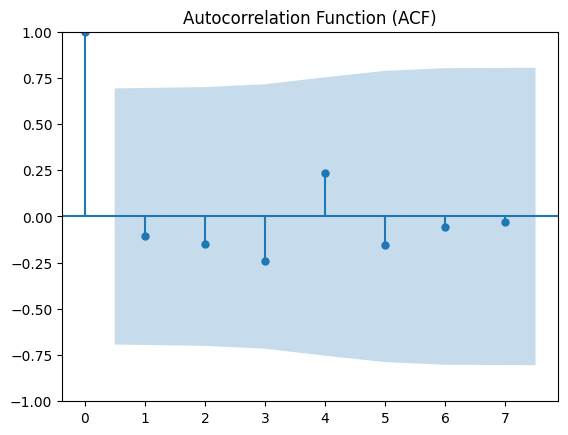

19


<Figure size 1200x600 with 0 Axes>

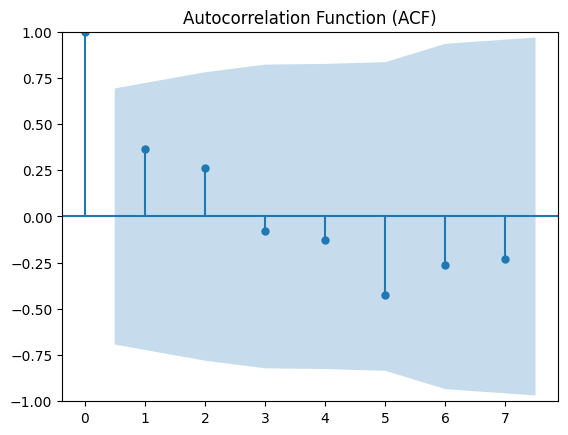

20


<Figure size 1200x600 with 0 Axes>

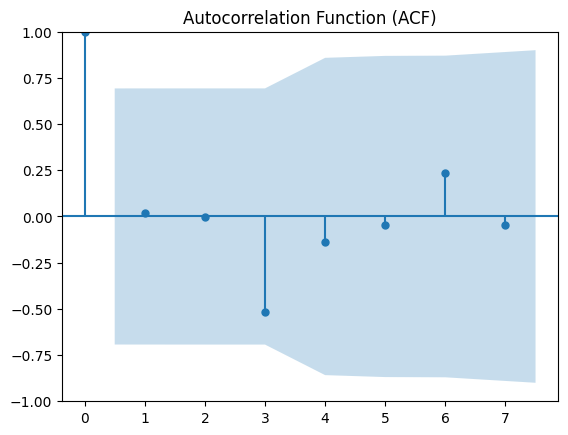

21


<Figure size 1200x600 with 0 Axes>

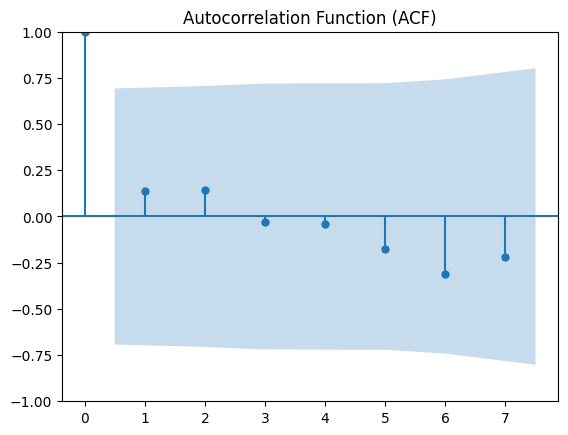

22


<Figure size 1200x600 with 0 Axes>

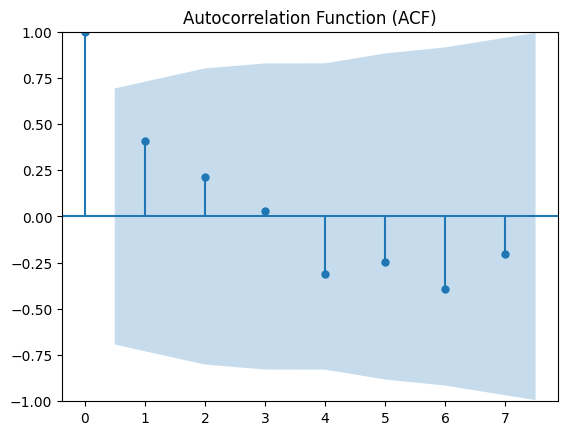

23


<Figure size 1200x600 with 0 Axes>

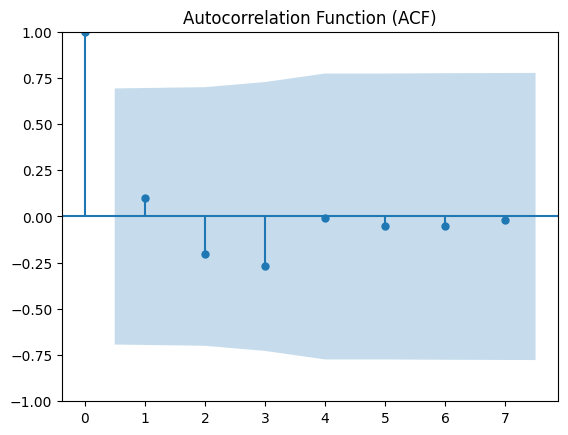

24


<Figure size 1200x600 with 0 Axes>

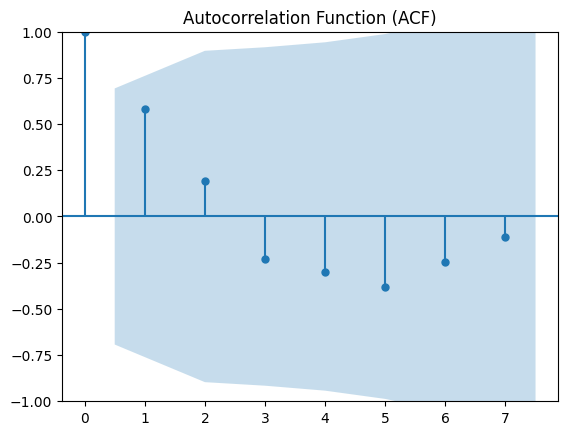

25


<Figure size 1200x600 with 0 Axes>

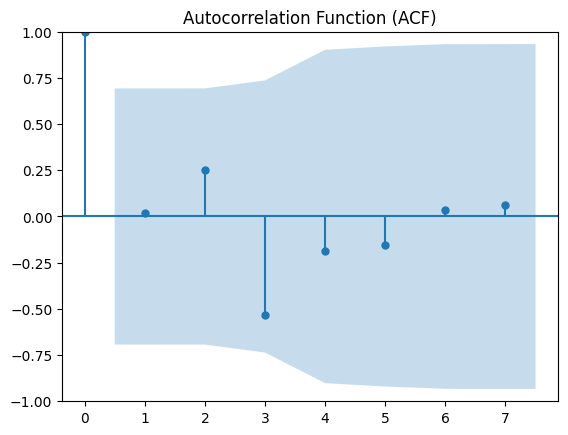

26


<Figure size 1200x600 with 0 Axes>

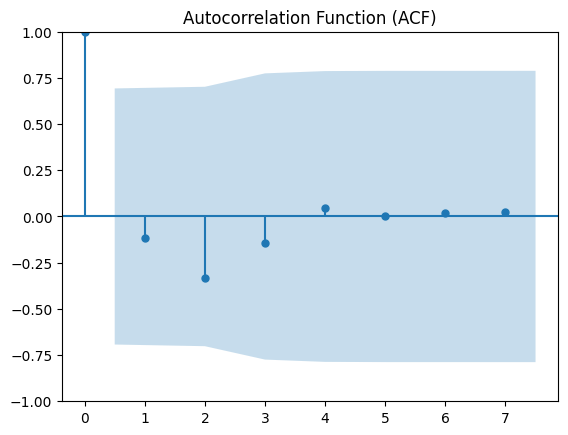

27


<Figure size 1200x600 with 0 Axes>

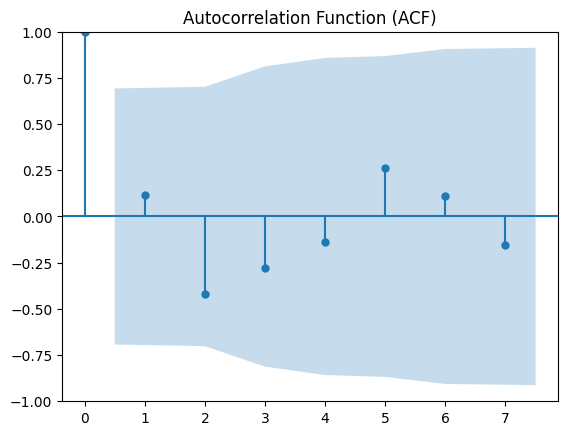

28


<Figure size 1200x600 with 0 Axes>

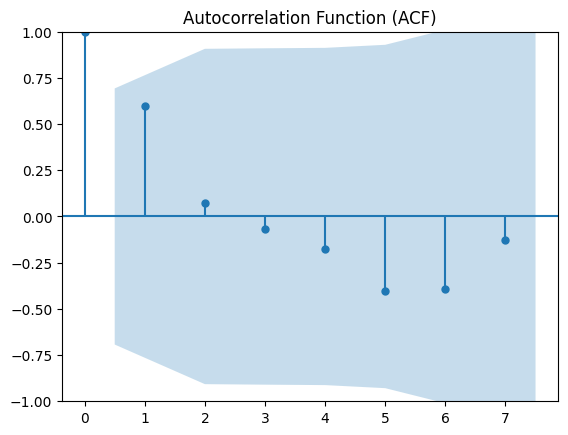

29


<Figure size 1200x600 with 0 Axes>

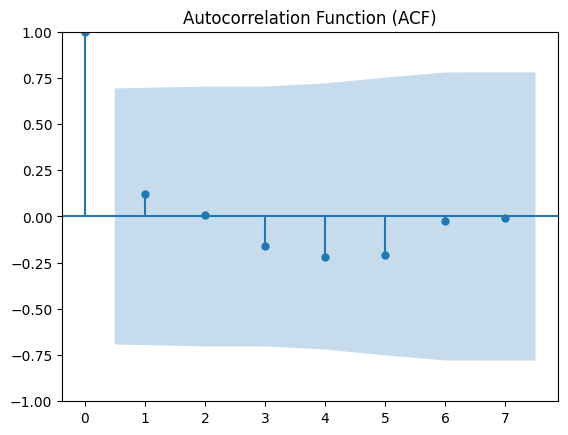

30


<Figure size 1200x600 with 0 Axes>

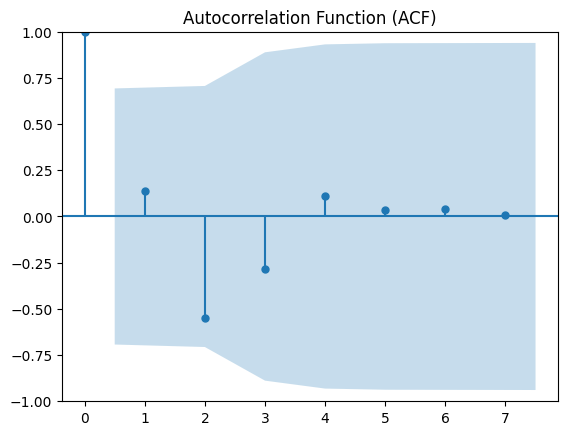

31


<Figure size 1200x600 with 0 Axes>

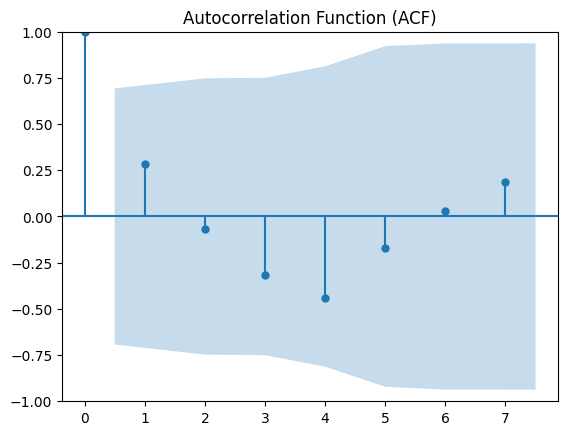

32


<Figure size 1200x600 with 0 Axes>

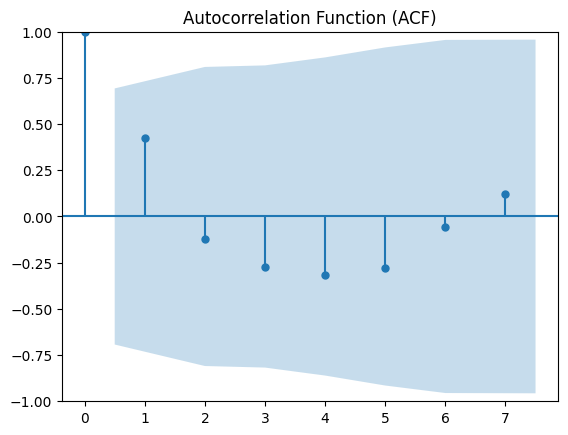

33


<Figure size 1200x600 with 0 Axes>

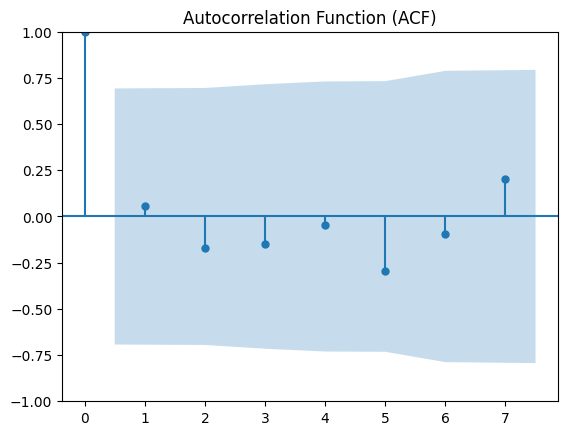

34


<Figure size 1200x600 with 0 Axes>

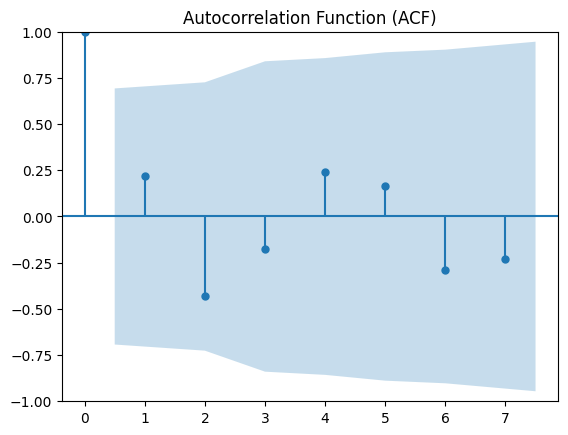

35


<Figure size 1200x600 with 0 Axes>

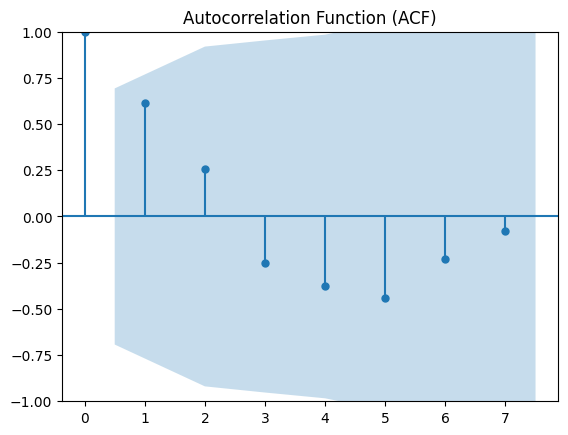

36


<Figure size 1200x600 with 0 Axes>

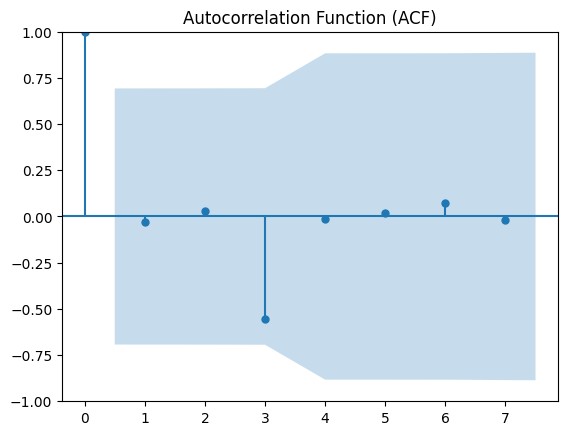

37


<Figure size 1200x600 with 0 Axes>

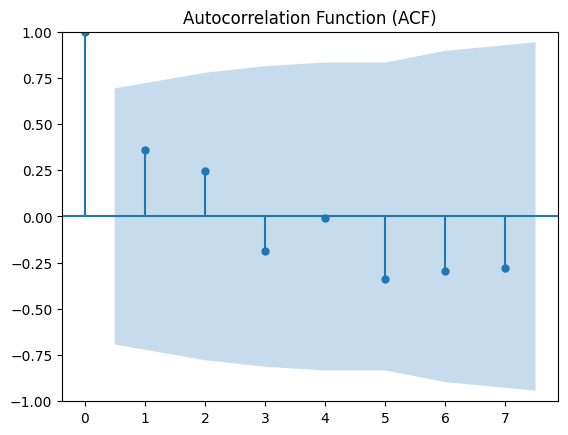

38


<Figure size 1200x600 with 0 Axes>

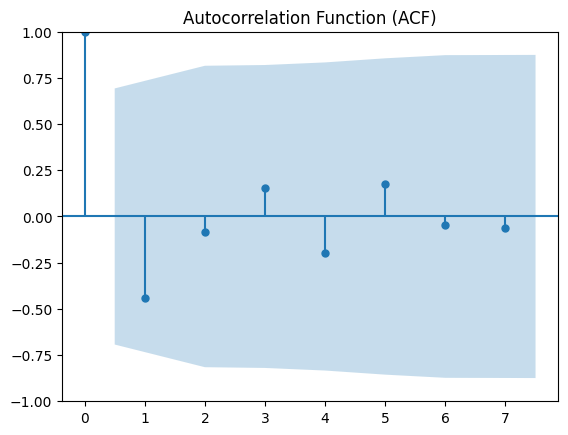

39


<Figure size 1200x600 with 0 Axes>

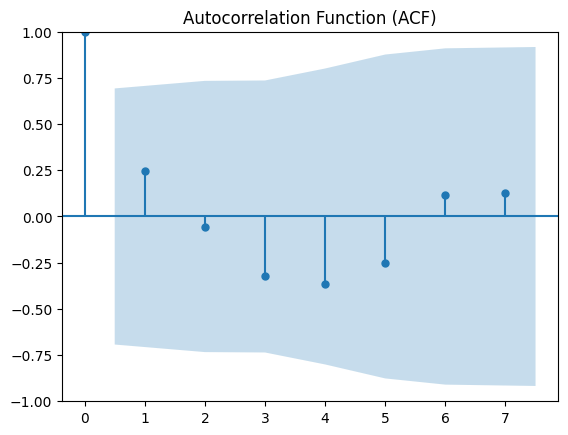

40


<Figure size 1200x600 with 0 Axes>

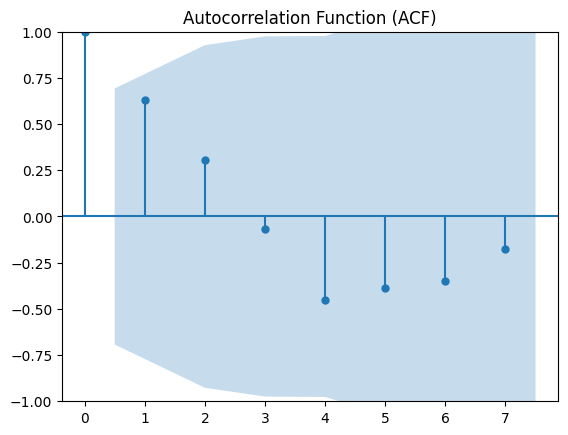

41


<Figure size 1200x600 with 0 Axes>

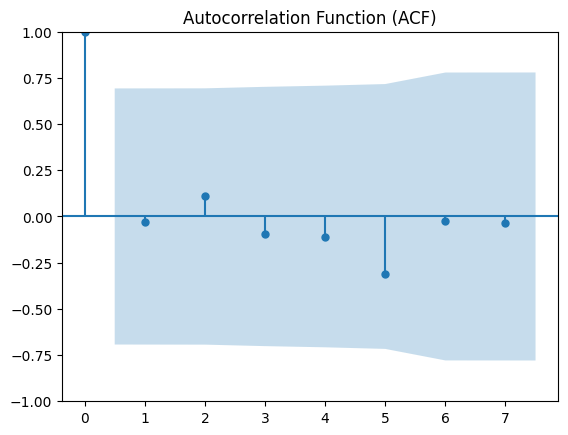

42


<Figure size 1200x600 with 0 Axes>

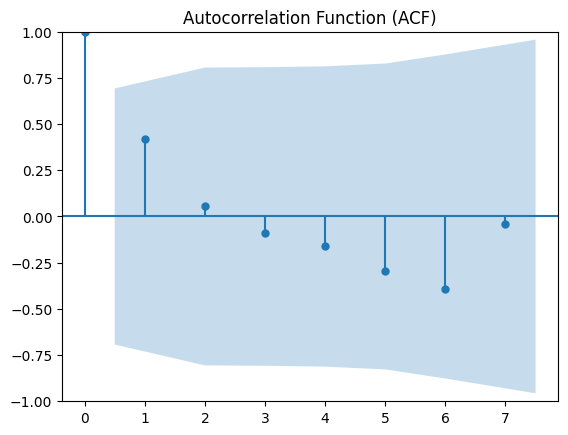

43


<Figure size 1200x600 with 0 Axes>

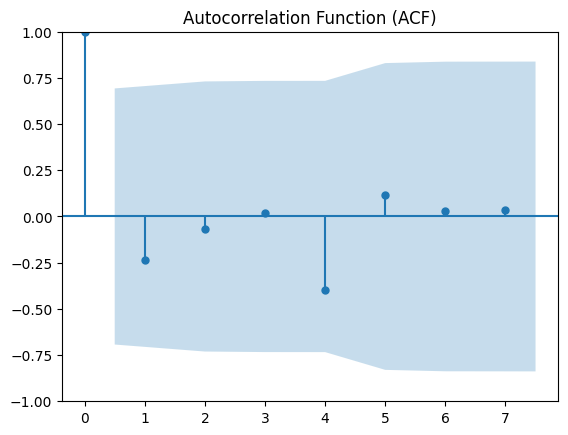

44


<Figure size 1200x600 with 0 Axes>

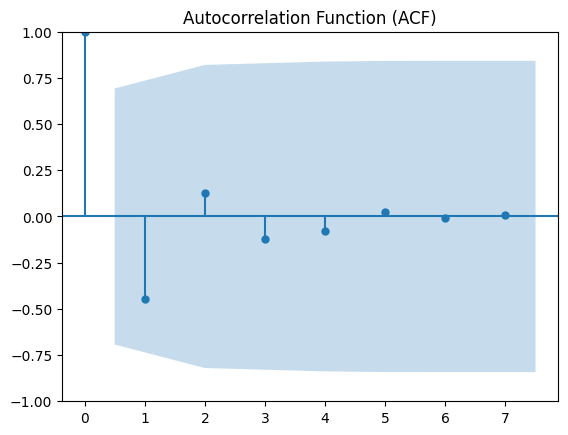

45


<Figure size 1200x600 with 0 Axes>

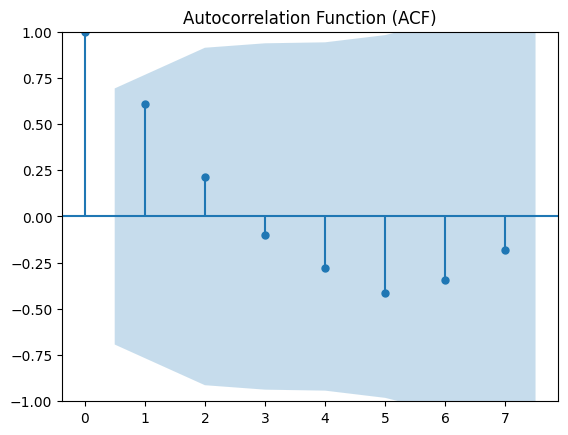

46


<Figure size 1200x600 with 0 Axes>

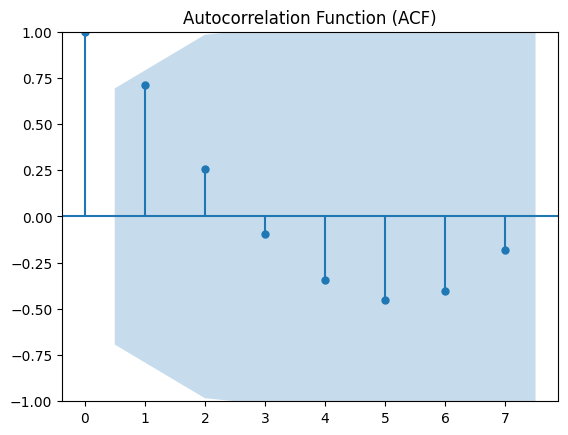

47


<Figure size 1200x600 with 0 Axes>

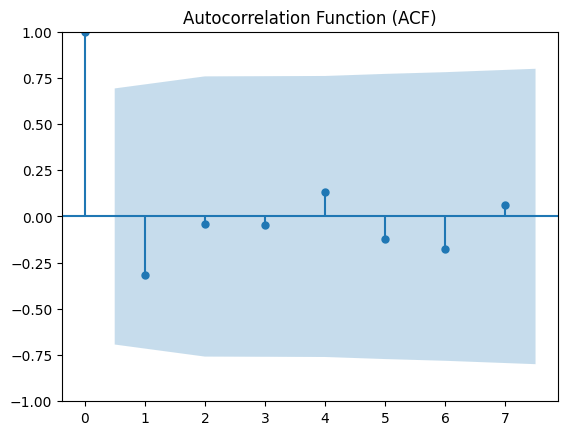

48


<Figure size 1200x600 with 0 Axes>

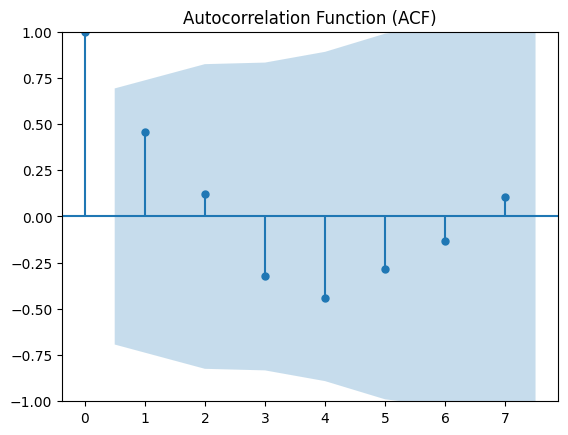

49


<Figure size 1200x600 with 0 Axes>

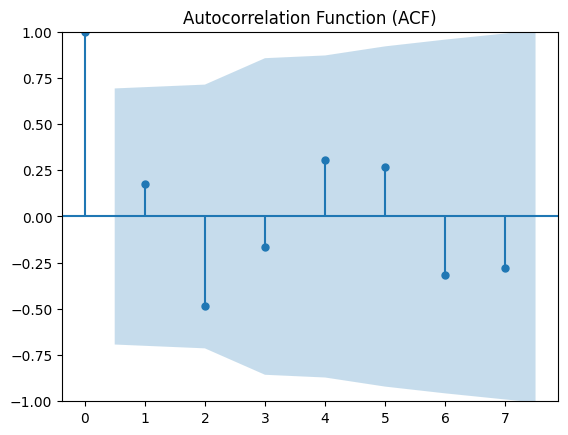

50


<Figure size 1200x600 with 0 Axes>

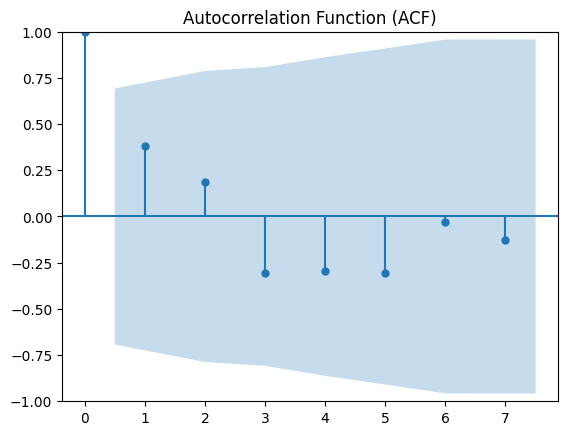

51


<Figure size 1200x600 with 0 Axes>

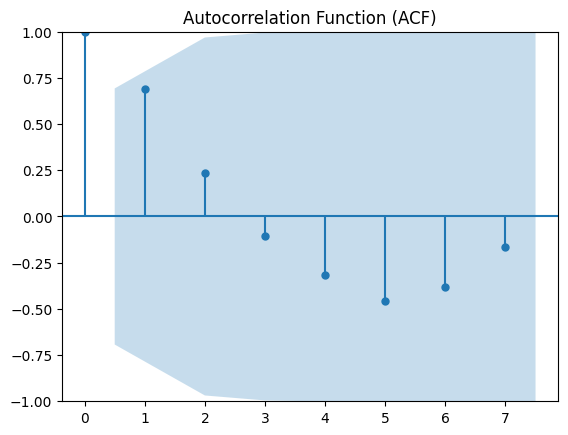

52


<Figure size 1200x600 with 0 Axes>

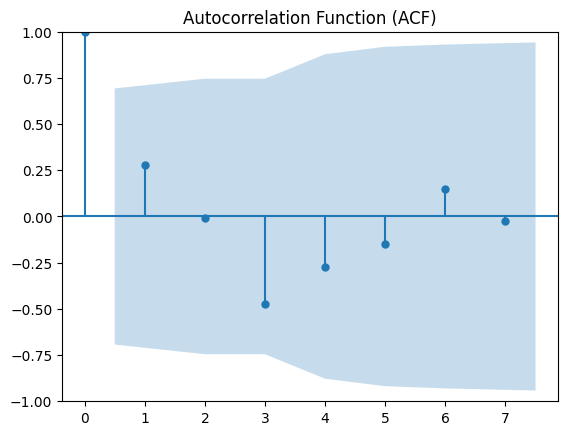

53


<Figure size 1200x600 with 0 Axes>

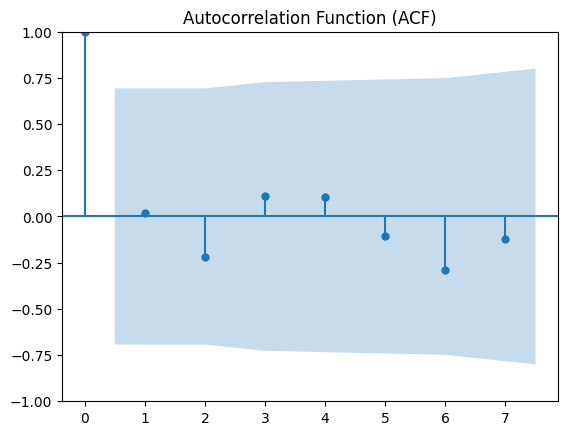

54


<Figure size 1200x600 with 0 Axes>

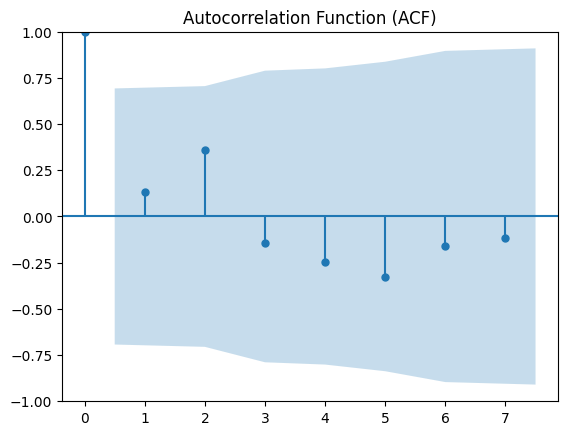

55


<Figure size 1200x600 with 0 Axes>

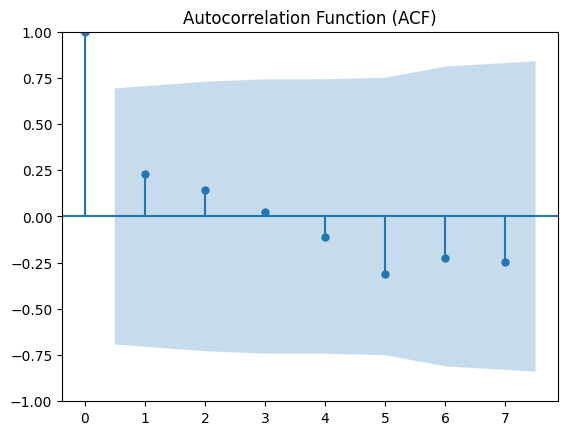

56


<Figure size 1200x600 with 0 Axes>

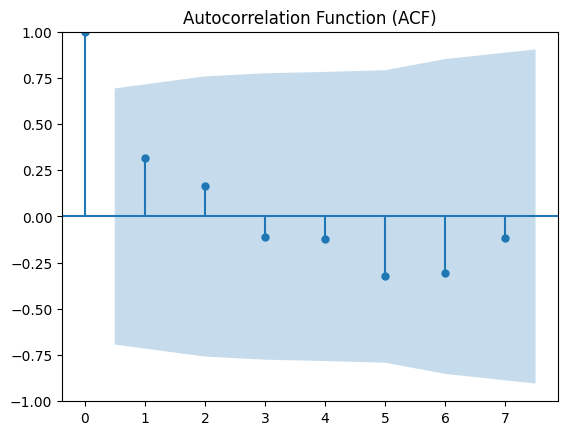

57


<Figure size 1200x600 with 0 Axes>

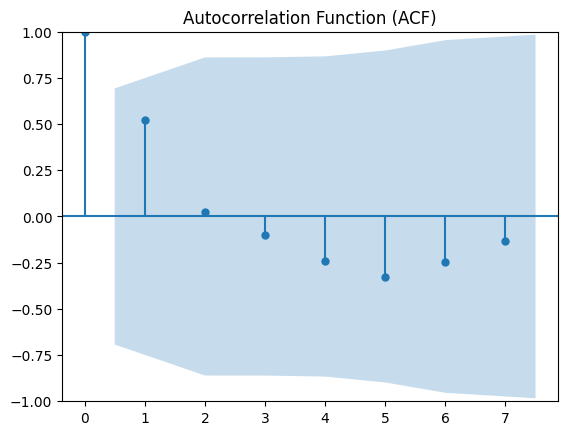

58


<Figure size 1200x600 with 0 Axes>

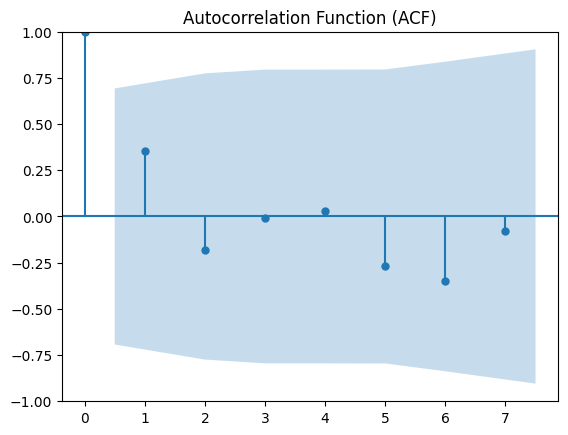

59


<Figure size 1200x600 with 0 Axes>

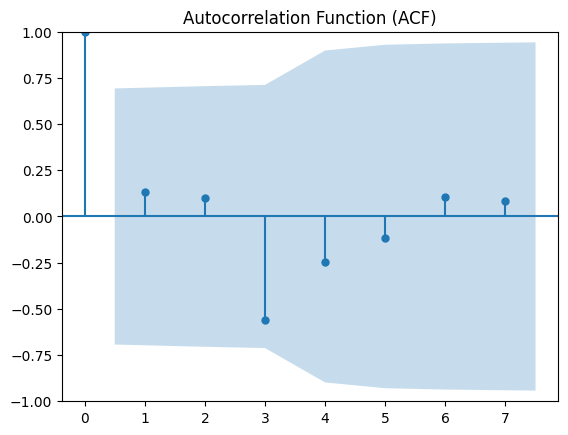

In [148]:
# Figure AutoCorrelations and Partial AutoCorrelations
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i in range(batch-cnt_thrown_idx):
    print (i)
# Plot the autocorrelation function (ACF)    
    plt.figure(figsize = (12, 6))
    plot_acf(values[i], lags = sl - 1)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()
    
# Plot the partial autocorrelation function (PACF)
    # plt.figure(figsize = (12, 6))
    # plot_pacf(values[round(i/2)], lags = 60)
    # plt.title('Partial Autocorrelation Function (PACF)')
    # plt.show()

In [158]:
print ("===================================================")
print ("sequence length:  ", sl)
print ("batch size:  ", batch-cnt_thrown_idx)
print ("no. of variables:  ", n_features)
print ("no. of predicted variables:  ", n_out)
print ("how many steps forward to predict:  ", frwd)
print ("===================================================")

sequence length:   8
batch size:   60
no. of variables:   8
no. of predicted variables:   1
how many steps forward to predict:   1


In [174]:
from keras.initializers import glorot_uniform, he_uniform, orthogonal, zeros

n_steps = sl

model_8f = Sequential()
model_8f.add(tf.keras.layers.Input(shape = (n_steps, n_features)))
# model_8f.add(tf.keras.layers.LSTM(units = 64, activation = 'relu', return_sequences = False))   

model_8f.add(tf.keras.layers.LSTM(
    units = 32,
    kernel_initializer = glorot_uniform(),    # Initialize the input weights
    recurrent_initializer = orthogonal(),     # Initialize the recurrent weights
    bias_initializer = zeros(),               # Initialize the biases
    activation = 'relu', 
    return_sequences = False
))

# model_8f.add(tf.keras.layers.Dropout(0.2)) 
model_8f.add(tf.keras.layers.RepeatVector(frwd))
model_8f.add(tf.keras.layers.LSTM(units = 32, activation = 'relu', return_sequences = True))
# model_8f.add(tf.keras.layers.Dropout(0.2)) 
model_8f.add(tf.keras.layers.TimeDistributed(Dense(units = n_out)))

# Compile the model with MSE loss computed for each time step

# sgd = SGD(learning_rate = 0.1)
# model_8f.compile(optimizer = sgd, loss = 'mse')
model_8f.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_8f.summary()

# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

# fit model
# The number of epochs is the number of complete passes through the training dataset
history = model_8f.fit(X, y, epochs = 500, 
                       validation_split = 0.2,
                       verbose = 2)
                       # , callbacks=[es])
                       # , callbacks = [TimeStepErrorLogger()])

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                  │ (None, 32)             │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_43 (RepeatVector) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 1, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 1, 1)           │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,601 (53.13 KB)

 Trainable params: 13,601 (53.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 - 6s - 2s/step - loss: 1577620.1250 - val_loss: 1035992.6875
Epoch 2/500
3/3 - 0s - 18ms/step - loss: 1006795.6875 - val_loss: 712147.4375
Epoch 3/500
3/3 - 0s - 17ms/step - loss: 922834.5000 - val_loss: 511394.2500
Epoch 4/500
3/3 - 0s - 17ms/step - loss: 428416.4062 - val_loss: 420227.0625
Epoch 5/500
3/3 - 0s - 18ms/step - loss: 406738.7812 - val_loss: 336247.9062
Epoch 6/500
3/3 - 0s - 17ms/step - loss: 214966.7500 - val_loss: 284008.7188
Epoch 7/500
3/3 - 0s - 17ms/step - loss: 272694.0312 - val_loss: 105427.6406
Epoch 8/500
3/3 - 0s - 17ms/step - loss: 241169.9531 - val_loss: 109991.3984
Epoch 9/500
3/3 - 0s - 17ms/step - loss: 176282.8281 - val_loss: 115337.9297
Epoch 10/500
3/3 - 0s - 17ms/step - loss: 321056.3750 - val_loss: 78467.2422
Epoch 11/500
3/3 - 0s - 17ms/step - loss: 200496.0000 - val_loss: 78079.6953
Epoch 12/500
3/3 - 0s - 17ms/step - loss: 215983.7031 - val_loss: 47101.2930
Epoch 13/500
3/3 - 0s - 17ms/step - loss: 96757.1328 - val_loss: 39729.7539

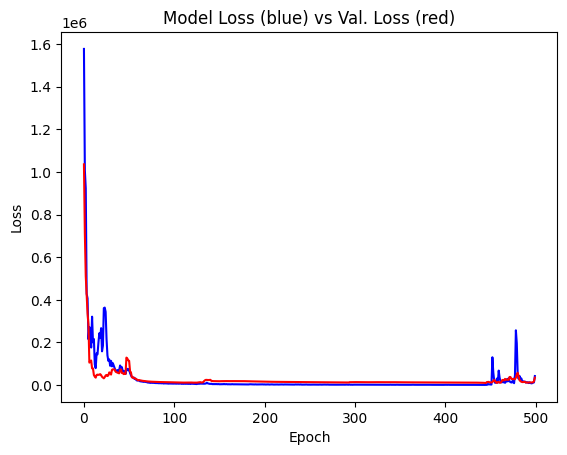

In [175]:
# Create a figure and axis object
fig, ax = plt.subplots(1, 1)

# Plot the data
ax.plot(history.history['loss'], 'blue')
ax.plot(history.history['val_loss'], 'red')

# Customize the plot
ax.set_title('Model Loss (blue) vs Val. Loss (red)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.show()

In [28]:
# Extract weights from the LSTM layer
lstm_layer = model_8f.layers[0]
lstm_weights = lstm_layer.get_weights()

In [29]:
kernel, recurrent_kernel, bias = lstm_weights

# Print the shapes
print(f"Kernel shape: {kernel.shape}")
print(f"Recurrent Kernel shape: {recurrent_kernel.shape}")
print(f"Bias shape: {bias.shape}")

Kernel shape: (8, 8)
Recurrent Kernel shape: (2, 8)
Bias shape: (8,)


In [223]:
# Print the weights
print("Kernel weights:", kernel)
print("Recurrent kernel weights:", recurrent_kernel)
print("Bias weights:", bias)

Kernel weights: [[ 0.05232579  0.01374082  0.01113737 ... -0.03336089  0.03715584
  -0.03538815]
 [ 0.03264289  0.02306121  0.02604442 ...  0.03129478 -0.05207984
   0.04096095]
 [-0.02632057 -0.02589257 -0.02369264 ... -0.03858705 -0.01252202
   0.00666459]
 ...
 [-0.01920575 -0.00956063  0.02410255 ...  0.01255936  0.04612235
   0.05381919]
 [ 0.04781022  0.01975601 -0.0432153  ...  0.05187599 -0.01336266
   0.03635232]
 [-0.03965205 -0.00055679 -0.03181865 ...  0.0390408  -0.0238521
   0.00138673]]
Recurrent kernel weights: [[-0.01153879 -0.00017272  0.0282393  ...  0.00996209  0.01181875
  -0.01943585]
 [ 0.01909763  0.00872338  0.02296009 ...  0.01635076  0.01008803
  -0.01466706]
 [ 0.02507331  0.0413265  -0.00896156 ...  0.01102871  0.00432566
   0.01624689]
 ...
 [-0.00220611 -0.00429316  0.03294532 ... -0.02962208  0.02178407
  -0.00670702]
 [ 0.00095747  0.00812461  0.00659628 ...  0.03368684 -0.05981153
   0.00807448]
 [ 0.00640679  0.01504548  0.01278104 ... -0.00735644 -0.

In [168]:
#  Validation Set - 06.18.2024
# ============================
# Reset Index
sample_valid = sample_valid.reset_index(drop = True)
sample_size = sample_valid.shape[0]
print ('sample_size: ', sample_size)
# sample_valid.head()
# sl = 8  # <--- sequence length
batch_valid = 10  # <--- batch size
# n_features = 8 # <---- no. of variables
# n_out = 1 # <----- no. of predicted variables
# frwd = 1  # <--- how many to predict

# Trimming Indices !!!
# Marking selected rows
sample_valid['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(374)
selected_indices = np.random.choice(sample_valid.index, size = batch_valid, replace = False)

sample_valid.loc[selected_indices, 'Selected'] = 1 # print (sample_valid[sample_valid['Selected'] == 1])
chosen_idx1 = sample_valid[sample_valid['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_valid.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_valid.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
    # Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)
    
# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
    # Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
    # Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]


X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0_valid = np.column_stack((X_XRP_close, X_XRP_volume, 
                      X_ETH_close, X_ETH_volume, 
                      X_LTC_close, X_LTC_volume, 
                      X_BTC_close, X_BTC_volume))
# print (X0)

# ======== Model Input =========
X_valid = X0_valid.reshape(batch_valid-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X_valid)
print (X_valid.shape)

y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]

# y_valid = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y_valid)

y_valid = y_BTC.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
print ('YYYY ====== Actual Input ====== YYYY')
print (y_valid)
print (y_valid.shape)

sample_size:  4485
[3444 2461 3517 2548 1172 3424  976 2268 1445 3323]
XXXX ====== Actual Input ====== XXXX
[[[4.91900000e-01 2.85165527e+04 3.67903000e-01 8.77595847e+01
   7.93500000e-01 4.74830980e+02 6.91327800e-01 1.06080062e+01]
  [4.95300000e-01 1.84248992e+04 3.67317000e-01 4.51914654e+01
   7.96300000e-01 7.50671488e+01 6.90076200e-01 7.32009821e+00]
  [4.95400000e-01 3.43324861e+04 3.67229000e-01 8.47281527e+01
   7.96100000e-01 1.14132468e+02 6.89944300e-01 5.18948335e+00]
  [4.95700000e-01 2.15298357e+05 3.67687000e-01 5.10162893e+01
   7.96800000e-01 6.55170188e+01 6.90316800e-01 4.38908488e+00]
  [4.96900000e-01 2.29025823e+05 3.67847000e-01 6.77505122e+01
   7.97500000e-01 2.27206460e+02 6.90792100e-01 5.71190279e+00]
  [4.97200000e-01 1.35593174e+05 3.68042000e-01 3.77163439e+01
   7.98400000e-01 5.48284123e+02 6.91105400e-01 4.84039589e+00]
  [4.97800000e-01 2.99639502e+05 3.67965000e-01 6.48344487e+01
   7.98100000e-01 1.76385979e+02 6.91101700e-01 8.32839892e+00]
  [

In [170]:
y_hat = model_8f.predict(X_valid, verbose = 1).reshape(batch_valid-cnt_thrown_idx, frwd)
# print (sl)

print ('y_valid')
print (type(y_valid))
print (y_valid.shape)
print (y_valid)
# print (y_valid[0:10])

print ('y_hat')
print (type(y_hat))
print (y_hat.shape)
print (y_hat)
# y_ht1 = y_hat.reshape(batch-cnt_thrown_idx, frwd)
# # print (y_hat[0:10])
# print (y_ht1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
y_valid
<class 'numpy.ndarray'>
(10, 1, 1)
[[[0.6915686]]

 [[0.6933044]]

 [[0.7122553]]

 [[0.6946416]]

 [[0.6940752]]

 [[0.6931973]]

 [[0.6952175]]

 [[0.6941199]]

 [[0.6946209]]

 [[0.6952265]]]
y_hat
<class 'numpy.ndarray'>
(10, 1)
[[ 8.0367511e+02]
 [ 1.3962366e+02]
 [ 5.3128414e+01]
 [-5.9378960e+01]
 [-6.6341087e+01]
 [-6.4128904e+00]
 [ 2.1907943e-03]
 [-1.9205887e+01]
 [-1.2864524e+01]
 [-9.5366278e+00]]




0


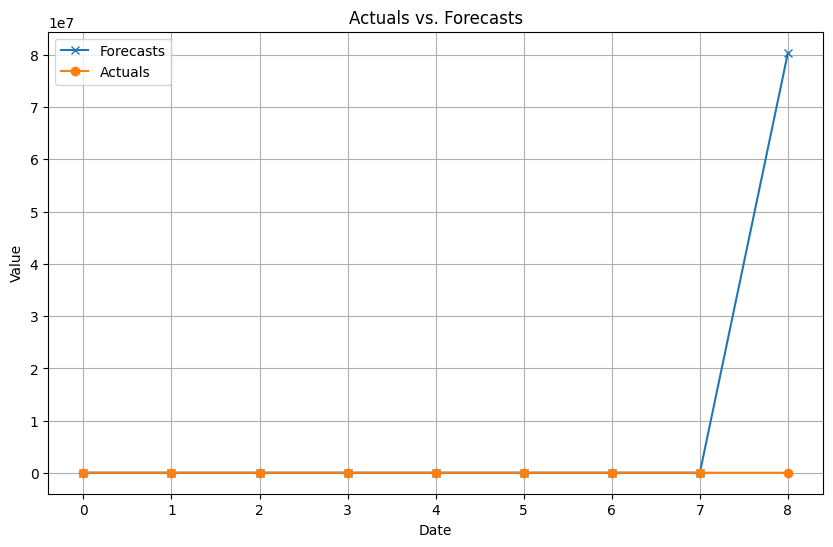



1


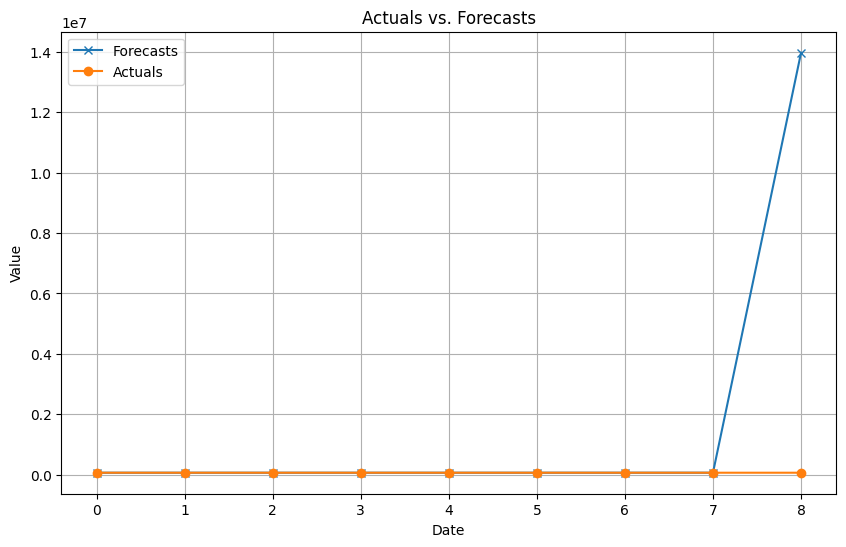



2


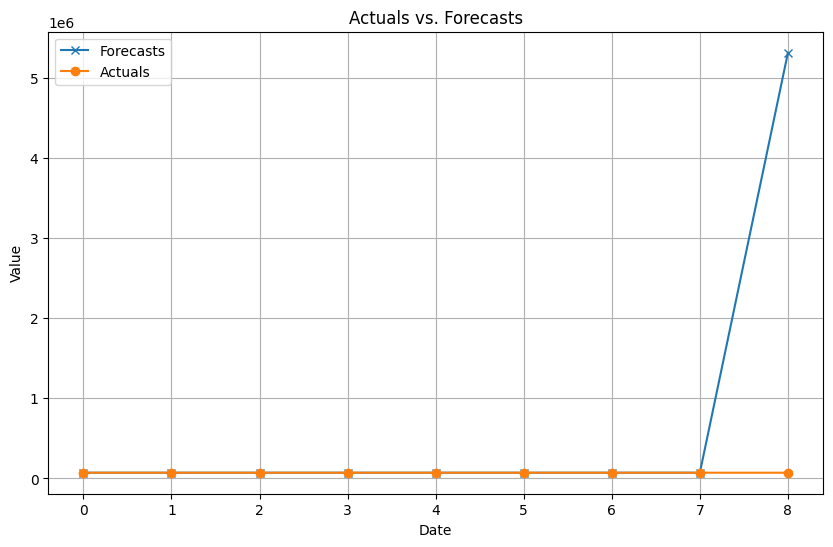



3


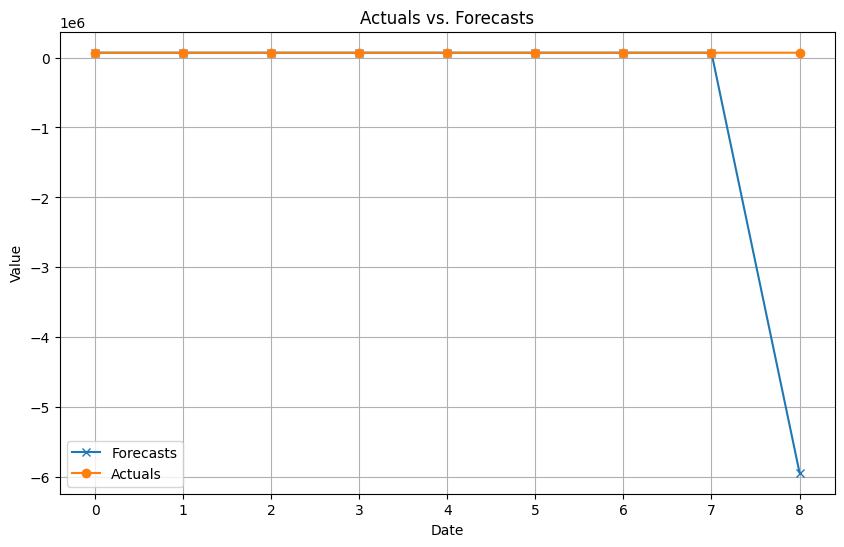



4


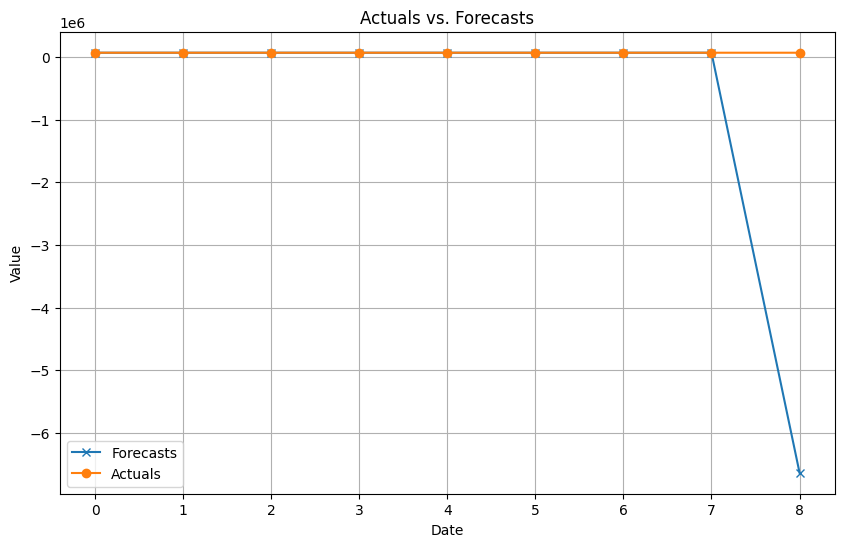



5


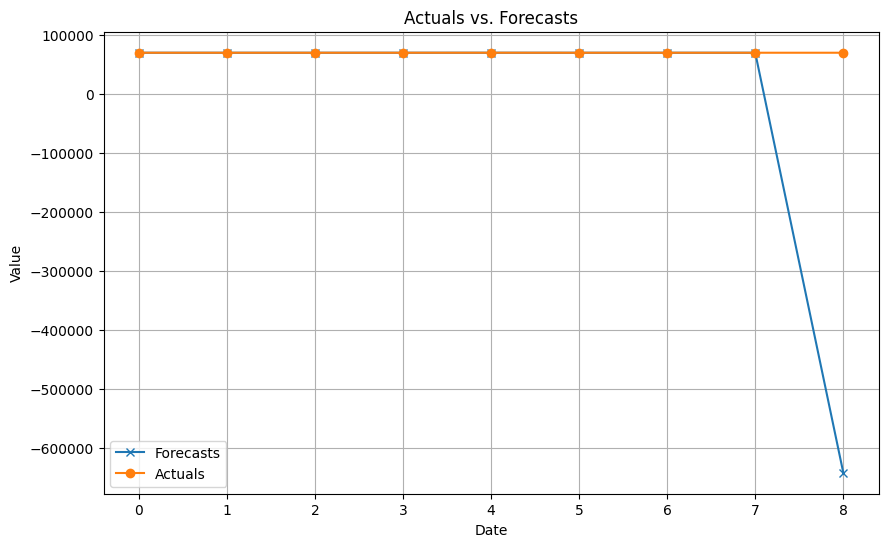



6


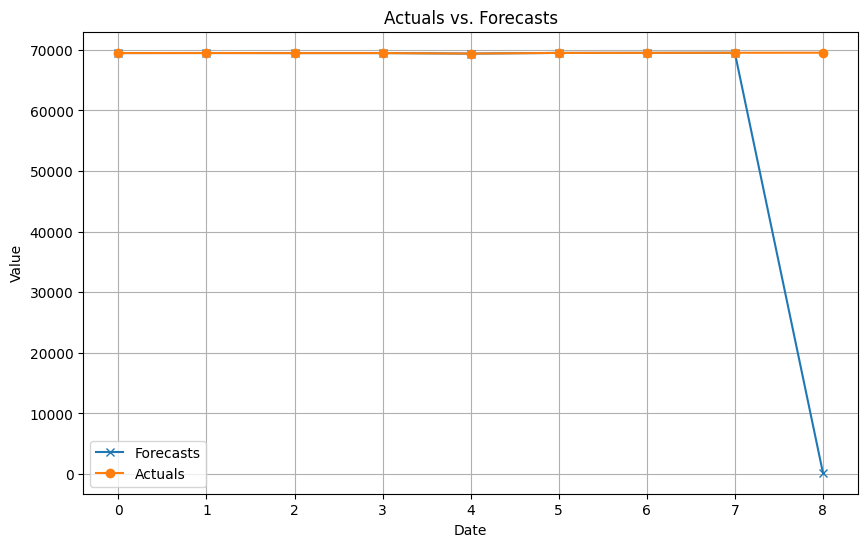



7


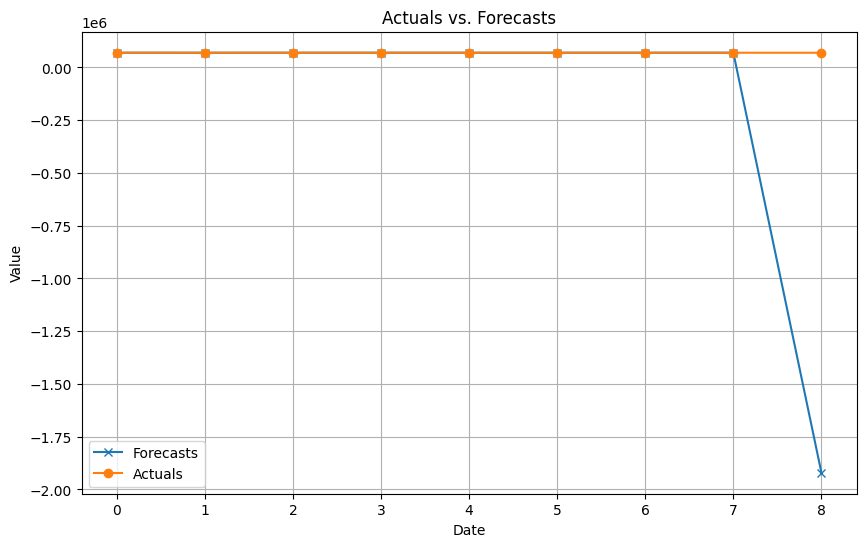



8


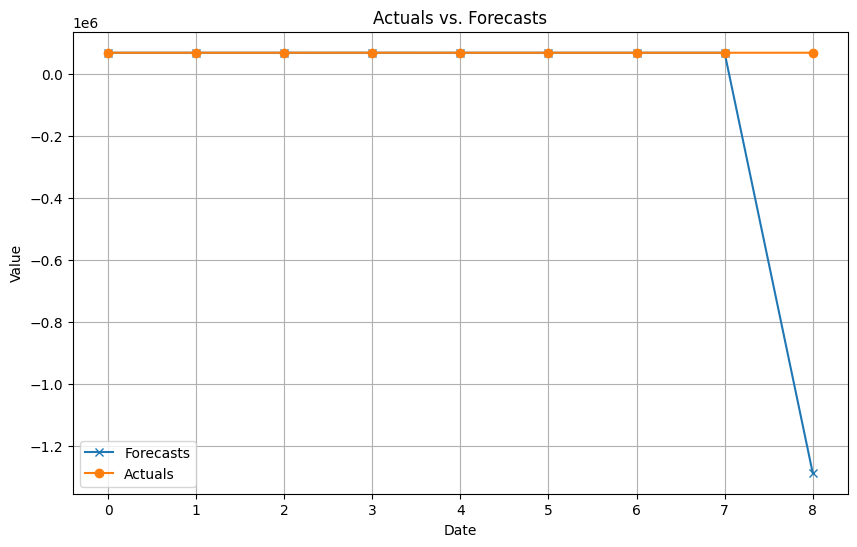



9


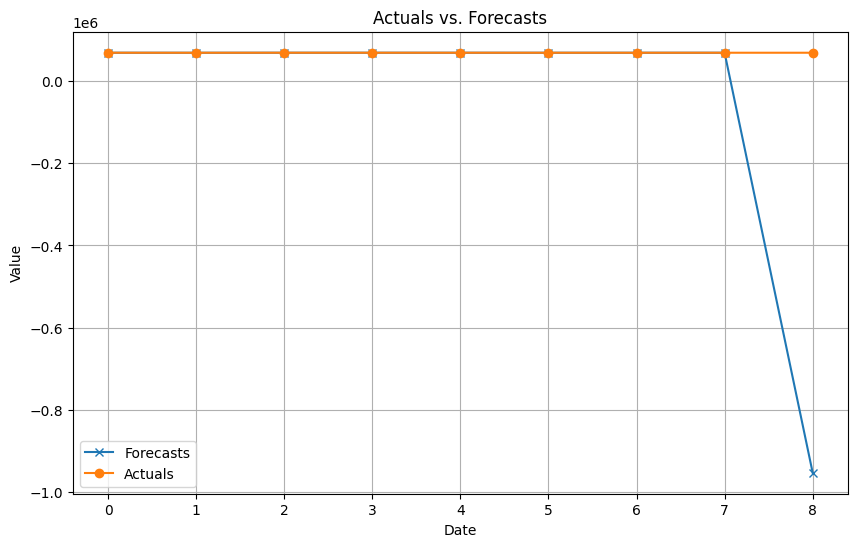

In [171]:
for i in range(batch_valid-cnt_thrown_idx):
    print ('\n')  
    print (i)
    X_resh = X_valid[i:i+1, :, 6].flatten()
    # print (X_resh)
    # print ('\n')
    y_resh = y_valid[i:i+1].flatten()
    # print (y_resh)
    y_est_resh = y_hat[i:i+1].flatten()
    # print (y_est_resh)
    # print ('\n')
    actual = np.concatenate((X_resh, y_resh)) * 100000.00
    # print (actual)
    # print ('\n')
    estimate = np.concatenate((X_resh, y_est_resh)) * 100000.00
    # print (estimate)

    dates = list(range(sl+frwd))
    
    # Create a pandas DataFrame
    data = pd.DataFrame({'Date': dates, 'Actuals': actual, 'Forecasts': estimate})
    
    # Set the 'Date' column as the index
    data.set_index('Date', inplace=True)
    
    # Create a figure and axis object using object-oriented style
    fig, ax = plt.subplots(figsize = (10, 6))
    
    # Plot actuals vs. forecasts
    ax.plot(data.index, data['Forecasts'], label = 'Forecasts', marker = 'x')
    ax.plot(data.index, data['Actuals'], label = 'Actuals', marker = 'o')
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title('Actuals vs. Forecasts')

    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()

In [255]:
print (sample_test.head(1))

    date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0  1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  Selected  
0     0.8317  110.056253  0.831662    0.67506    2.045049  0.674969         0  


In [1]:
# variables are volume and volume
# ==============================
#  Test Sample --- 06.14.2024
# ==============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

sl = 16  # <--- sequence length
batch = 10  # <--- batch size
n_features = 8 # <---- no. of variables
n_out = 1 # <----- no. of predicted variables
frwd = 1  # <--- how many to predict


# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

# all_ts_xrp = np.empty((1, )) # final input/output
# all_ts_eth = np.empty((1, )) # final input/output
# all_ts_ltc = np.empty((1, )) # final input/output
# all_ts_btc = np.empty((1, )) # final input/output


all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_xrp = np.empty((1))
aft_ts_eth = np.empty((1))
aft_ts_ltc = np.empty((1))
aft_ts_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
    # Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)
    
# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
    # Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
    # Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_tc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]


X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
                      X_ETH_close, X_ETH_volume, 
                      X_LTC_close, X_LTC_volume, 
                      X_BTC_close, X_BTC_volume))
print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X.shape)

y_XRP = aft_ts_xrp[1:]
y_ETH = aft_ts_eth[1:]
y_LTC = aft_ts_ltc[1:]
y_BTC = aft_ts_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
print (y)

y = y_BTC.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y.shape)

NameError: name 'sample_test' is not defined